In [2]:
import sys
sys.path.append("/home/tinkerer/spin-qubit/codes/")
sys.path.insert(0, "/home/tinkerer/Poisson_Solver/")

import numpy as np
from collections import OrderedDict
from ccode.plotting import plot_gates
from scipy import constants

from Hamiltonian import discrete_system_coordinates, kwant_system, tight_binding_Hamiltonian
from potential import gate_potential, linear_problem_instance
from utility import prepare_voltages
from plotting import plot_potential
from layout import (
    Layout,
    OverlappingGateLayer,
    PlanarGateLayer,
    SimpleChargeLayer,
    SimpleVoltageLayer,
    TwoDEGLayer,
)

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [3]:
def rectangular_gate(center, length, width):
    """
    Returns vertices of a gate
    """
    x, y = center

    gate = np.array(
        [
            [-width/2, -length/2],
            [-width/2, length/2],
            [width/2, length/2],
            [width/2, -length/2]
        ]
    )
    gate[:, 0] += x
    gate[:, 1] += y

    return gate


def half_disk_gate(R, center=(0, 0), npts=3):
    """
    Return vertices of a ring shaped
    """
    x, y = center
    
    angles = np.linspace(0, np.pi, npts)
    
    xs = x + np.cos(angles)*R
    ys = y + np.sin(angles)*R
    
    return np.vstack([xs, ys]).T


def ring_gate(R, r, center=(0, 0), npts=20):
    """
    asdasd
    """
    x, y = center

    angles = np.linspace(0, np.pi, npts)

    Xs = x + np.cos(angles)*R
    Ys = y + np.sin(angles)*R    

    xs = x + np.cos(angles)*r
    ys = y + np.sin(angles)*r
    
    out_ring = np.vstack([Xs, Ys]).T
    in_ring = np.vstack([xs, ys]).T[::-1]
    
    return np.vstack([out_ring, in_ring])

In [4]:
R = 40
wire_width = 7
r = R-7
gap = 10
tunel_length = 5
y_shift = tunel_length + gap

In [5]:
screen_gates = {}
screen_gates['disk_screen'] = half_disk_gate(R=r-gap, center=(0, y_shift))

plunger_gates = {}
x_c_P = R-wire_width/2
y_c = tunel_length/2
width_P = R - 3/2 * wire_width - 2 * gap
plunger_gates['ring_plunger'] = ring_gate(R=R, r=r, center=(0, y_shift))
#plunger_gates['ring_plunger_2'] = ring_gate(R=2*R, r=R+5*gap, center=(0, y_shift))
screen_gates['left_plunger'] = rectangular_gate(center=(-x_c_P/2, y_c), length=tunel_length, width=width_P)
plunger_gates['right_plunger'] = rectangular_gate(center=(x_c_P/2, y_c), length=tunel_length, width=width_P)
#plunger_gates['disk_screen'] = half_disk_gate(R=r-gap, center=(0, y_shift))

tunel_gates = {}
x_c_T = R - wire_width/2
tunel_gates['left_tunel'] = rectangular_gate(center=(-x_c_T, y_c), length=tunel_length, width=wire_width)
tunel_gates['central_tunel'] = rectangular_gate(center=(0, y_c), length=tunel_length, width=wire_width)
tunel_gates['right_tunel'] = rectangular_gate(center=(x_c_T, y_c), length=tunel_length, width=wire_width)

In [6]:
gates = {'plunger_gates': plunger_gates, 'screen_gates': screen_gates, 'tunel_gates': tunel_gates}

In [7]:
gates = {'plunger_gates': plunger_gates, 'screen_gates': screen_gates}

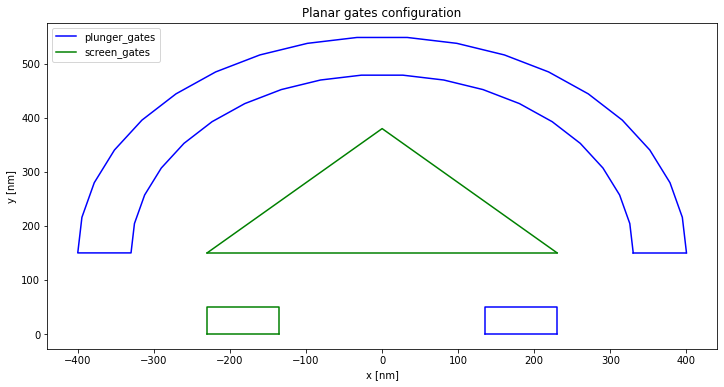

In [8]:
plot_gates(gates)

In [9]:
thickness_GaAs = 6
thickness_twoDEG = 4
thickness_Al2O3 = 4
thickness_gate = 2
thickness_self_Al2O3 = 4

meff = 0.023 * constants.m_e  # in Kg
eV = 1.0
bandgap_GaAs = 1.519 * eV

permittivity_metal = 5000
permittivity_GaAs = 12.18
permittivity_twoDEG = 15  # InAs
permittivity_air = 1.0
permittivity_Al2O3 = 9.1

grid_spacing_twoDEG = 1
grid_spacing_normal = 1
grid_spacing_dielectric = 5
grid_spacing_air = 5
grid_spacing_GaAs = grid_spacing_normal
grid_spacing_gate = grid_spacing_twoDEG

density = 1.9e11  # Electron density in 2DEG per cm2
cm = 1.0
m = 1e2 * cm
density_m2 = density * m ** 2  # Electron density in 2DEG per m2
#scaling_eV = 1 / (constants.e)  # in eV
#mu = (((constants.hbar ** 2) * np.pi * density_m2) / meff) * scaling_eV

In [10]:
zmin = -0.5
zmax = 0.5
xmax = R
xmin = -R
ymin = 0
ymax = R + y_shift
boundaries = [xmin, xmax, ymin, ymax, zmin, zmax]

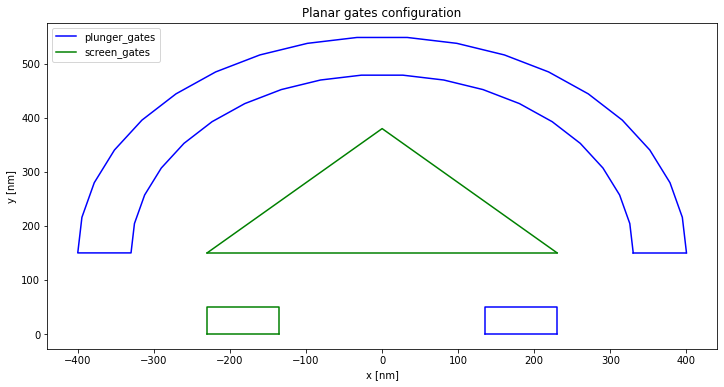

In [11]:
plot_gates(gates)

In [12]:
total_length = ymax
total_width = 2 * xmax

In [13]:
layout = Layout(
    total_width, total_length, grid_width_air=grid_spacing_air, margin=(50, 50, 50), shift=(0, total_length/2, 0)
)

In [14]:
layout.add_layer(
    TwoDEGLayer(
        "twoDEG",
        thickness_twoDEG,
        permittivity_twoDEG,
        grid_spacing_twoDEG
    ),
    center=True,
)

layout.add_layer(
    SimpleChargeLayer(
        "GaAs",
        thickness_GaAs,
        permittivity_GaAs,
        grid_spacing_GaAs,
    )
)

In [15]:
vertex = (
    list(gates["plunger_gates"].values()), 
    list(gates["screen_gates"].values()),     
        )

layout.add_layer(
    OverlappingGateLayer(
        vertex,
        np.hstack([list(gates[key].keys()) for key, _ in gates.items()]),
        thickness_gate,
        thickness_self_Al2O3,
        permittivity_metal,
        grid_spacing_gate,
    )
)

In [16]:
%%time
poisson_system = layout.build()
linear_problem = linear_problem_instance(poisson_system)



------------------------------------------------






------------------------------------------------






------------------------------------------------






/home/tinkerer/Poisson_Solver/poisson/continuous/geometry.py:68: RuntimeWarning:  
 
 voltage functions are not well defined.
 Their intersection is not empty. 
 Check poisson.system.System or poisson.geometry.Geometry class attribute 
 sub_regions_intersection for a list of the index of the points belonging to 
 the intersection 
 
  warnings.warn(warning_message, RuntimeWarning)


AssertionError: Error: there are overlapping regions.

In [280]:
site_coords, site_indices = discrete_system_coordinates(
    poisson_system, [('mixed', 'twoDEG')], boundaries=boundaries
)

In [281]:
# %%px --local

model = "A0 * (k_x**2 + k_y**2) + V(x, y)"

A0 = (constants.hbar) ** 2 / (2 * meff * constants.e * (10e-9) ** 2)


def onsite(site, A0, V):
    (x, y,) = site.pos
    _const_0 = V(x, y)
    return (4 / (grid_spacing) ** 2) * A0 + _const_0


def hopping(site1, site2, A0):
    return -(1 / (grid_spacing) ** 2) * A0


grid_spacing = grid_spacing_twoDEG
kwant_syst = kwant_system(site_coords[:, [0, 1]], onsite, hopping, grid_spacing)
kwant_sites = np.array([site.pos for site in kwant_syst.sites])

In [282]:
kwant.plot(kwant_syst, site_size=0.3, site_color='r', hop_color='b',);

NameError: name 'kwant' is not defined

In [283]:
# parameters for trijunction builder
a = 1
L = boundaries[3] - boundaries[2]
W = boundaries[1] - boundaries[0]
crds = site_coords[:, [0, 1]]
offset = crds[0]%grid_spacing

# Potential set up: plunger gate

In [284]:
# voltages left and right

plunger_voltages = {'ring_plunger': 0.001, 'left_plunger': 0.006, 'right_plunger': 0.006}

voltage_setup_CR.update(plunger_voltages)

volt = list(voltage_setup_CR.values())
gates = list(voltage_setup_CR.keys())
voltage_setup = prepare_voltages(volt, gates)

In [285]:
electrons = 1.0  # We consider electrons

sign_potential_energy = -1.0 if electrons else 1.0

In [286]:
def f_potential(voltage_setup, offset=offset, grid_spacing=1):
    charges = {}
    clean_potential = gate_potential(
        poisson_system,
        linear_problem,
        site_coords[:, [0, 1]],
        site_indices,
        voltage_setup,
        charges,
        offset,
        grid_spacing
    )

    return clean_potential

In [287]:
clean_potential = f_potential(voltage_setup=voltage_setup)
clean_potential.update(
    (key, sign_potential_energy * value) for key, value in clean_potential.items()
)

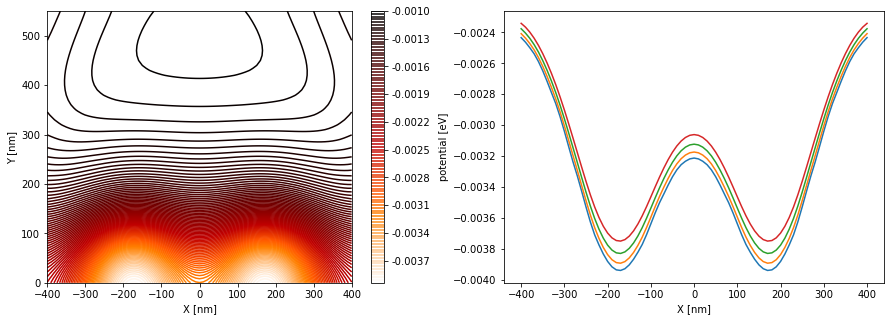

In [288]:
plot_potential([clean_potential], [0.0, 10.0, 20.0, 30.0], scale=10)